In [1]:
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# Importing the dataset
dataset=pd.read_csv('Ola_Dataset1.csv')
dataset.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis,label
0,0,not that it will matter to you no zamato swi...,1.00,1.0,Positive,1.0
1,1,Happy church day ⛪⛪ Marriott Hotel Downtown A...,1.00,0.8,Positive,1.0
2,2,Over drivers in London register on Ola Great ...,0.75,0.8,Positive,1.0
3,3,It would be great if you chain me in this ap...,0.75,0.8,Positive,1.0
4,4,Just wait Sir will sooner you face a welcome ...,0.90,0.8,Positive,1.0


In [3]:
#Removing the unnecessary columns.
dataset = dataset[['label','tweet']]

# Replacing the values.
dataset['tweet'] = dataset['tweet'].replace(4,1)

In [4]:
dataset.head()
len(dataset.index)

690

In [5]:
dataset=dataset.dropna()
len(dataset.index)

459

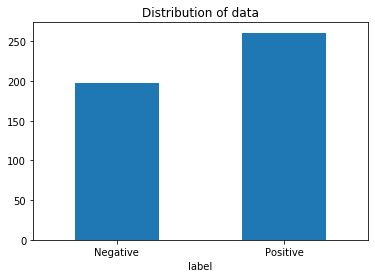

In [6]:
ax = dataset.groupby('label').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [7]:
contractions = pd.read_csv('contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    weet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [8]:
%%time
dataset['processed_text'] = dataset.tweet.apply(preprocess_apply)

Wall time: 34.9 ms


In [9]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text:   not that it will matter to you no zamato swiggy ola or amazon or flipkart Agra is cut off from the world and mind u in peak tourist season what a wonderful message will tourist take home on the govt of    
Processed:   not that it will matter to you no zamato swiggy ola or amazon or flipkart agra is cut off from the world and mind u in peak tourist season what a wonderful message will tourist take home on the govt of  
Text: Happy church day ⛪⛪  Marriott Hotel Downtown Abu Dhabi  httpstcoOVDosxpg
Processed: happy church day     marriott hotel downtown abu dhabi  httpstcoovdosxpg
Text: Over  drivers in London register on Ola Great job   httpstcocGJQUutve
Processed: over  drivers in london register on ola great job  httpstcocgjquutve
Text:   It would be great if you chain me in this appreciation
Processed:   it would be great if you chain me in this appreciation
Text:  Just wait Sir will sooner you face a welcome fire after shouting  hu 
Processed:  just wait sir will sooner you 

In [10]:
processedtext = list(dataset['processed_text'])
data_pos = processedtext[:263]
data_neg = processedtext[263:]


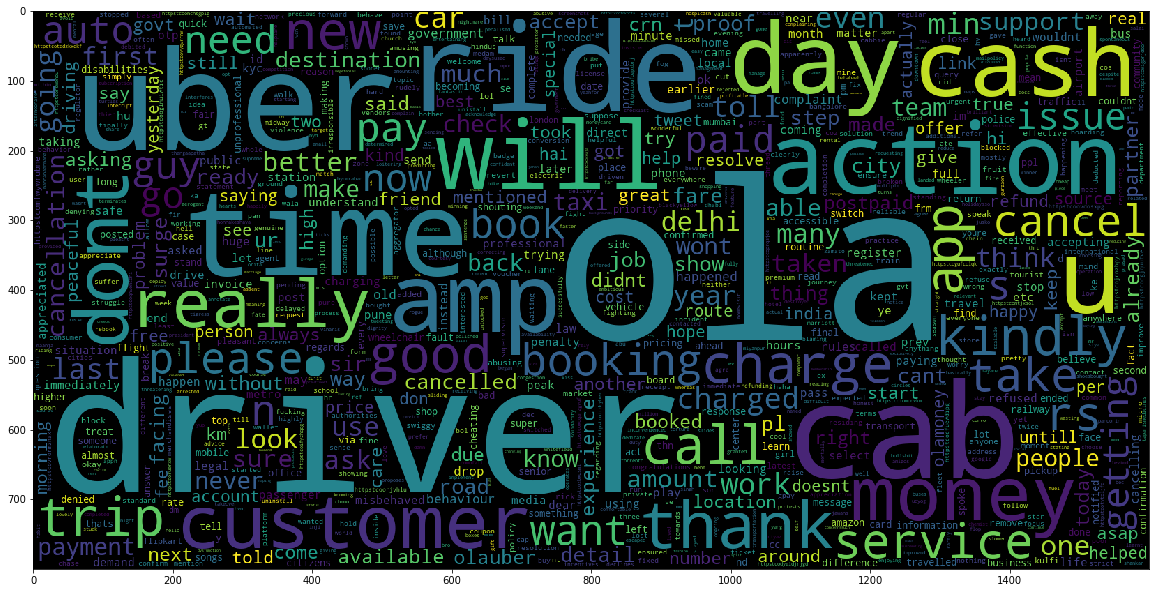

In [11]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

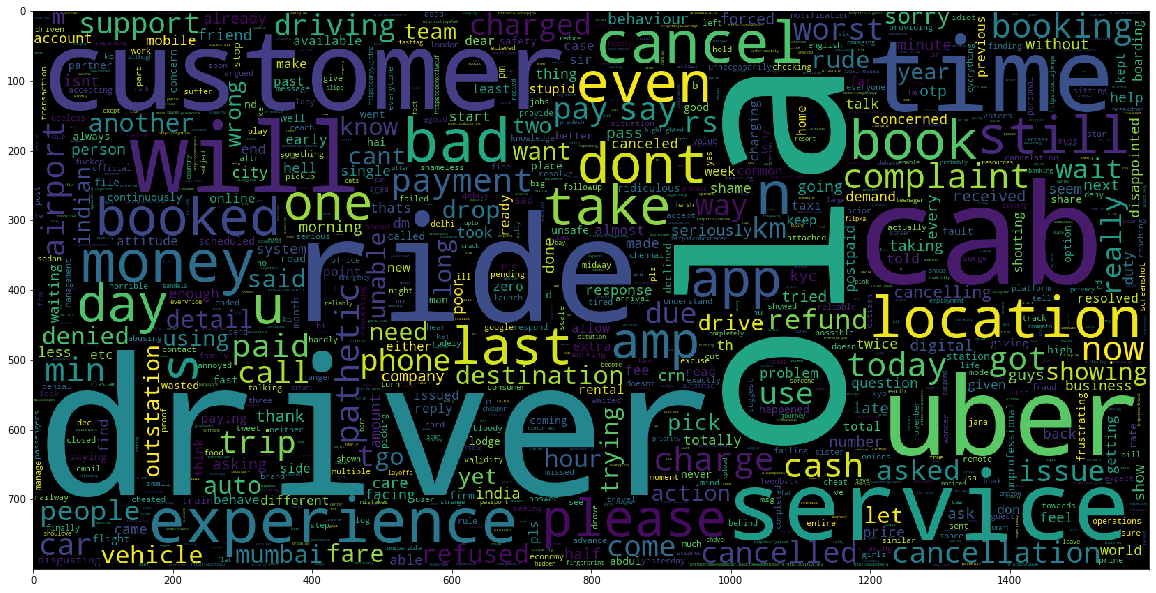

In [12]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [13]:
from sklearn.model_selection import train_test_split

In [64]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['label'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.4, random_state = 101)
print('Data Split done.')

Data Split done.


In [65]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [66]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.vocab))

Vocabulary Length: 284
Wall time: 91.5 ms


In [67]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [68]:
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)

vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 2686


In [69]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (275, 60)
X_test.shape : (184, 60)


In [70]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (2686, 100)


In [71]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [72]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length, 
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix], 
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [73]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 100)           268600    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 60, 200)           160800    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 60, 200)           240800    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 56, 100)           100100    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_7 (Dense)              (None, 1)             

In [74]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [75]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [76]:
history = training_model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
3/3 [==============================] - 2s 680ms/step - loss: 0.6951 - accuracy: 0.4494 - val_loss: 0.6930 - val_accuracy: 0.5357
Epoch 2/12
3/3 [==============================] - 1s 253ms/step - loss: 0.6922 - accuracy: 0.5506 - val_loss: 0.6924 - val_accuracy: 0.5357
Epoch 3/12
3/3 [==============================] - 1s 257ms/step - loss: 0.6930 - accuracy: 0.5506 - val_loss: 0.6919 - val_accuracy: 0.5357
Epoch 4/12
3/3 [==============================] - 1s 419ms/step - loss: 0.6901 - accuracy: 0.5506 - val_loss: 0.6911 - val_accuracy: 0.5357
Epoch 5/12
3/3 [==============================] - 1s 262ms/step - loss: 0.6910 - accuracy: 0.5506 - val_loss: 0.6912 - val_accuracy: 0.5357
Epoch 6/12
3/3 [==============================] - 2s 518ms/step - loss: 0.6888 - accuracy: 0.5506 - val_loss: 0.6907 - val_accuracy: 0.5357


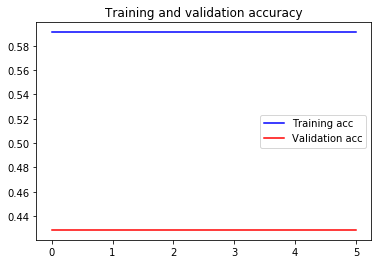

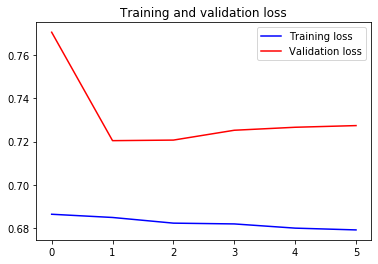

In [31]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [28]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

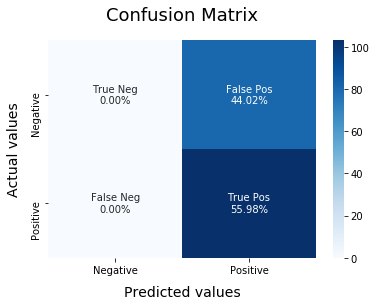

In [29]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        81
         1.0       0.56      1.00      0.72       103

    accuracy                           0.56       184
   macro avg       0.28      0.50      0.36       184
weighted avg       0.31      0.56      0.40       184



C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
